In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('adult.csv', na_values = ['#NAME?'])
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
print(df['income'].value_counts())
df['income'] = [0 if x == '<=50K' else 1 for x in df['income']]
#Assign X as a DataFrame of features and y as a Series of the outcome variable
X = df.drop('income', 1)
y = df.income
print(X.head())
print(y.head())

<=50K    37155
>50K     11687
Name: income, dtype: int64
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0

In [4]:
# Convert Categorical/Ordinal to Numeric
# Dummy coding: get_dummies in pandas or OneHotEncoder in sci-kit learn
print(pd.get_dummies(X['education']).head())

   10th  11th  12th  1st-4th  5th-6th  7th-8th  9th  Assoc-acdm  Assoc-voc  \
0     0     1     0        0        0        0    0           0          0   
1     0     0     0        0        0        0    0           0          0   
2     0     0     0        0        0        0    0           1          0   
3     0     0     0        0        0        0    0           0          0   
4     0     0     0        0        0        0    0           0          0   

   Bachelors  Doctorate  HS-grad  Masters  Preschool  Prof-school  \
0          0          0        0        0          0            0   
1          0          0        1        0          0            0   
2          0          0        0        0          0            0   
3          0          0        0        0          0            0   
4          0          0        0        0          0            0   

   Some-college  
0             0  
1             0  
2             0  
3             1  
4             1  


In [6]:
# Decide which categorical variables you want to use in model
for col_name in X.columns:
    if X[col_name].dtypes == 'object':
        unique_cat = len(X[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name = col_name, unique_cat = unique_cat))

Feature 'workclass' has 9 unique categories
Feature 'education' has 16 unique categories
Feature 'marital-status' has 7 unique categories
Feature 'occupation' has 15 unique categories
Feature 'relationship' has 6 unique categories
Feature 'race' has 5 unique categories
Feature 'gender' has 2 unique categories
Feature 'native-country' has 42 unique categories


In [8]:
print(X['native-country'].value_counts().sort_values(ascending = False).head())

United-States    43832
Mexico             951
?                  857
Philippines        295
Germany            206
Name: native-country, dtype: int64


In [10]:
X['native-country'] = ['United-States' if x == 'United-States' else 'Other' for x in X['native-country']]
print(X['native-country'].value_counts().sort_values(ascending = False))

United-States    43832
Other             5010
Name: native-country, dtype: int64


In [11]:
# Create a list of features to dummy 
todummy_list = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
# Function to dummy all categorical variables
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix = x, dummy_na = False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis = 1)
    return df

X = dummy_df(X, todummy_list)
print(X.head(1))

   age  fnlwgt  educational-num  capital-gain  capital-loss  hours-per-week  \
0   25  226802                7             0             0              40   

   workclass_?  workclass_Federal-gov  workclass_Local-gov  \
0            0                      0                    0   

   workclass_Never-worked  ...  relationship_Wife  race_Amer-Indian-Eskimo  \
0                       0  ...                  0                        0   

   race_Asian-Pac-Islander  race_Black  race_Other  race_White  gender_Female  \
0                        0           1           0           0              0   

   gender_Male  native-country_Other  native-country_United-States  
0            1                     0                             1  

[1 rows x 68 columns]


## Missing Data

In [19]:
X.isnull().sum().sort_values(ascending = False).head()

native-country_United-States    0
education_Bachelors             0
education_1st-4th               0
education_5th-6th               0
education_7th-8th               0
dtype: int64

In [18]:
# Impute Missing values using Imputer in sklearn.preprocessing
from sklearn.impute import SimpleImputer
 
imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
imp.fit(X)
X = pd.DataFrame(data = imp.transform(X), columns = X.columns)

## Outlier Detection

In [20]:
# Method 1
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1
    floor = q1 - 1.5 * iqr
    ceiling = q3 + 1.5 * iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])
    
    return outlier_indices, outlier_values

tukey_indices, tukey_values = find_outliers_tukey(X['age'])
print(np.sort(tukey_values))

[79. 79. 79. 79. 79. 79. 79. 79. 79. 79. 79. 79. 79. 79. 79. 79. 79. 79.
 79. 79. 79. 79. 79. 79. 79. 79. 79. 79. 79. 79. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 81. 81. 81. 81.
 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81.
 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 81. 82. 82. 82.
 82. 82. 82. 82. 82. 82. 82. 82. 82. 82. 82. 82. 83. 83. 83. 83. 83. 83.
 83. 83. 83. 83. 83. 84. 84. 84. 84. 84. 84. 84. 84. 84. 84. 84. 84. 84.
 85. 85. 85. 85. 85. 86. 87. 87. 87. 88. 88. 88. 88. 88. 88. 89. 89. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.
 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.]


In [24]:
# Method 2 Kernel Density Estimation
from sklearn.preprocessing import scale
import statsmodels.api as sm

def find_outliers_kde(x):
    x_scaled = scale(list(map(float, x)))
    kde = sm.nonparametric.KDEUnivariate(x_scaled)
    kde.fit(bw = "scott", fft = True)
    pred = kde.evaluate(x_scaled)
    
    n = sum(pred < 0.05)
    outlier_ind = np.asarray(pred).argsort()[:n]
    outlier_value = np.asarray(x)[outlier_ind]
    
    return outlier_ind, outlier_value

kde_indices, kde_values = find_outliers_kde(X['age'])
print(np.sort(kde_values))

KeyboardInterrupt: 

## Distribution of Features 

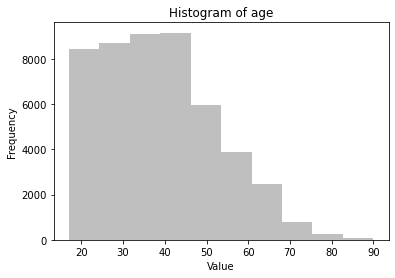

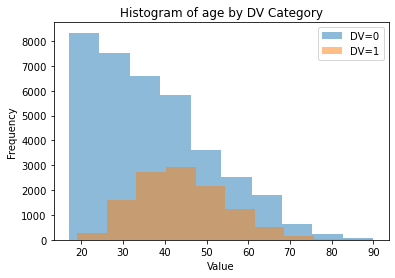

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_histograms(x):
    plt.hist(x, color = 'gray', alpha = 0.5)
    plt.title("Histogram of {var_name}".format(var_name = x.name))
    plt.xlabel("Value")
    plt.ylabel('Frequency')
    plt.show()
    
plot_histograms(X['age'])

def plot_histograms_dv(x, y):
    plt.hist(list(x[y==0]), alpha = 0.5, label = 'DV=0')
    plt.hist(list(x[y==1]), alpha = 0.5, label = 'DV=1')
    plt.title("Histogram of {var_name} by DV Category".format(var_name = x.name))
    plt.xlabel("Value")
    plt.ylabel('Frequency')
    plt.legend(loc = 'upper right')
    plt.show()
    
plot_histograms_dv(X['age'], y)

## Feature Engineering
- Add dimensionality
- Reduce dimensionality

In [30]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def add_interactions(df):
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    # Find interactions 
    poly = PolynomialFeatures(interaction_only = True, include_bias = False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    # Remove interaction terms with all 0 values
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis = 1)
    
    return df 

X = add_interactions(X)
print(X.head(3))

    age    fnlwgt  educational-num  capital-gain  capital-loss  \
0  25.0  226802.0              7.0           0.0           0.0   
1  38.0   89814.0              9.0           0.0           0.0   
2  28.0  336951.0             12.0           0.0           0.0   

   hours-per-week  workclass_?  workclass_Federal-gov  workclass_Local-gov  \
0            40.0          0.0                    0.0                  0.0   
1            50.0          0.0                    0.0                  0.0   
2            40.0          0.0                    0.0                  1.0   

   workclass_Never-worked  ...  race_Other_native-country_Other  \
0                     0.0  ...                              0.0   
1                     0.0  ...                              0.0   
2                     0.0  ...                              0.0   

   race_Other_native-country_United-States  race_White_gender_Female  \
0                                      0.0                       0.0   
1        

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
X_pca = pd.DataFrame(pca.fit_transform(X))

print(X_pca.head(3))

              0             1             2             3             4  \
0 -2.017217e+08 -1.667885e+07  1.873905e+05 -2.091049e+06 -3.544552e+05   
1 -2.017239e+08 -1.672363e+07 -4.771779e+06 -6.290287e+05 -3.632957e+05   
2 -2.017189e+08 -1.662251e+07  6.289177e+06 -2.365242e+06  1.158349e+06   

              5              6              7             8             9  
0  24953.578118  103135.785198 -187426.393409 -64843.228695  69959.080756  
1  40006.136716  -95078.461277    -933.342817  34055.284707  39946.235820  
2 -46306.506555 -436786.720482  133283.156598 -11840.276317  18606.250414  


## Feature Selection and Model Building

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.70, random_state = 1)

In [35]:
print(df.shape)
print(X.shape)

(48842, 15)
(48842, 1891)


In [37]:
import sklearn.feature_selection

select = sklearn.feature_selection.SelectKBest(k = 20)
selected_features = select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices = True)
colnames_selected = [X.columns[i] for i in indices_selected]

X_train_selected = X_train[colnames_selected]
X_test_selected = X_test[colnames_selected]

colnames_selected

/Users/oo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 350  663  824  829  834  992 1127 1164 1208 1315 1324 1327 1437 1628
 1631] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/oo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


['educational-num',
 'marital-status_Married-civ-spouse',
 'relationship_Husband',
 'age_educational-num',
 'age_marital-status_Married-civ-spouse',
 'age_relationship_Husband',
 'fnlwgt_marital-status_Married-civ-spouse',
 'fnlwgt_relationship_Husband',
 'educational-num_hours-per-week',
 'educational-num_marital-status_Married-civ-spouse',
 'educational-num_relationship_Husband',
 'hours-per-week_marital-status_Married-civ-spouse',
 'hours-per-week_relationship_Husband',
 'marital-status_Married-civ-spouse_relationship_Husband',
 'marital-status_Married-civ-spouse_race_White',
 'marital-status_Married-civ-spouse_gender_Male',
 'marital-status_Married-civ-spouse_native-country_United-States',
 'relationship_Husband_race_White',
 'relationship_Husband_gender_Male',
 'relationship_Husband_native-country_United-States']

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def find_model_perf(X_train, y_train, X_test, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_hat = [x[1] for x in model.predict_proba(X_test)]
    auc = roc_auc_score(y_test, y_hat)
    return auc

auc_processed = find_model_perf(X_train_selected, y_train, X_test_selected, y_test)
print(auc_processed)

0.6823389090747917


/Users/oo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
